In [1]:
import sys, os
import random

import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats

import matplotlib.pyplot as plt

In [2]:
standard_pfits = pd.read_pickle('./gridsearch-results/standard-participant_fits.pd.pkl')
obmdp_pfits = pd.read_pickle('./gridsearch-results/obmdp-participant_fits.pd.pkl')

In [3]:
exp_trials = pd.read_pickle('../data/exp2-demon_trajs.pd.pkl')
exp_trials['traj_len'] = exp_trials['traj'].apply(lambda t: len(t))

In [4]:
p_datapointcounts = exp_trials.groupby('participant').\
    apply(lambda rs: sum([len(r['traj']) for _, r in rs.iterrows()]))
p_datapointcounts = pd.DataFrame({
    'participant':p_datapointcounts.index, 
    'datapoint_count':p_datapointcounts.values
})

In [5]:
sns.set_palette(sns.color_palette([
    '#0072b2', '#009e73','#d55e00',  '#cc79a7', '#f0e442', '#56b4e9'
]))

# Condition-wise tests

In [6]:
pfits_comparison = \
    obmdp_pfits[['cond', 'participant', 'loglikelihood']].\
    merge(
        standard_pfits, on='participant', 
        suffixes=('_obmdp', '_standard')
    ).merge(
        p_datapointcounts, on='participant')

cond_steps = exp_trials.groupby(['cond', 'participant'])\
    ['traj_len'].sum().reset_index()
cond_steps = cond_steps.rename(columns={'traj_len': 'n_steps'})
pfits_comparison = pfits_comparison.merge(cond_steps,
                                          on=['cond', 'participant'])

## Log-likelihood ratio test

In [7]:
def calc_chi2_pval(LLR_test_stat, df):
    return scipy.stats.chi2.sf(x=LLR_test_stat, df=df)

In [8]:
pfits_comparison['obmdp_df'] = 7
pfits_comparison['standard_df'] = 4
pfits_comparison['df_diff'] = \
    pfits_comparison['obmdp_df'] - pfits_comparison['standard_df']

    
cond_loglike = pfits_comparison.groupby('cond')\
    [['loglikelihood_obmdp', 'loglikelihood_standard', 
      'n_steps', 'obmdp_df', 'standard_df', 'df_diff']].sum()

cond_loglike['LLR_test_stat'] = \
    2*(cond_loglike['loglikelihood_obmdp'] 
       - cond_loglike['loglikelihood_standard'])

cond_loglike['p_value'] = cond_loglike.apply(
    lambda r: calc_chi2_pval(r['LLR_test_stat'], r['df_diff']), 
    axis=1)
cond_loglike[['loglikelihood_obmdp', 
              'loglikelihood_standard',
              'df_diff',
              'LLR_test_stat',
              'p_value']]

,loglikelihood_obmdp,loglikelihood_standard,df_diff,LLR_test_stat,p_value
cond,,,,,
do,-912.742171,-999.874956,117,174.265569,4.735466e-04
show,-3344.269078,-4008.389581,123,1328.241005,3.560643e-201


### Bootstrap technique

In [10]:
pfits_comparison['LLR_test_stat'] = \
    2*(pfits_comparison['loglikelihood_obmdp'] - 
       pfits_comparison['loglikelihood_standard'])

# randomly re-label the samples
# and calculate the new difference in means
def gen_reordered_sample(pooled, size1, size2):
    np.random.shuffle(pooled)
    new1 = pooled[:size1]
    new2 = pooled[-size2:]
    return new1.mean() - new2.mean()

pooled = pfits_comparison['LLR_test_stat'].copy()
counts = tuple(pfits_comparison.groupby('cond')['participant'].count())

np.random.seed(1234)
n_samples = 10000
estimates = [gen_reordered_sample(pooled, *counts) for _ in range(n_samples)]
estimates = np.array(estimates)

pfits_comparison.groupby('cond')['LLR_test_stat'].aggregate(['mean', 'std'])

,mean,std
cond,,
do,4.468348,6.389740
show,32.396122,26.897527


In [11]:
mean_LLR_test_stats = pfits_comparison.groupby('cond')['LLR_test_stat'].mean()
mean_diff = mean_LLR_test_stats['do'] - mean_LLR_test_stats['show']
print(mean_LLR_test_stats)
print(mean_diff)
print(((estimates < mean_diff).sum() + 1)/(len(estimates) + 1))

cond
do       4.468348
show    32.396122
Name: LLR_test_stat, dtype: float64
-27.92777413622631
9.999000099990002e-05


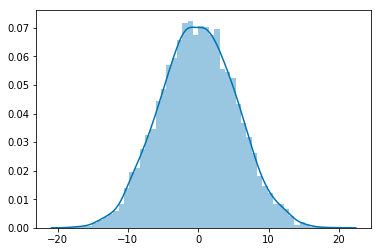

In [12]:
ax = sns.distplot(estimates)

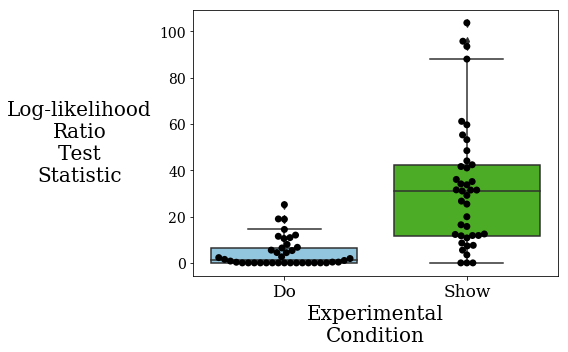

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.swarmplot(
    ax=ax,
    data=pfits_comparison,
    y='LLR_test_stat',
    x='cond',
    color="black",
    edgecolor="white",
    size=7,
    order=["do", "show"]
)
sns.boxplot(
    ax=ax,
    data=pfits_comparison,
    y='LLR_test_stat',
    x='cond',
    order=["do", "show"]
)
ax.set_ylabel("Log-likelihood\nRatio\nTest\nStatistic", 
              fontsize=20,
              family='serif',
              rotation=0, 
              labelpad=80,
              va='center')
plt.setp(ax.get_yticklabels(), 
         fontsize=14, family='serif')
_ = ax.set_xticklabels(["Do", "Show"],
                       fontsize=17, family='serif')
_ = ax.set_xlabel("Experimental\nCondition",
                  fontsize=20, family='serif')
plt.tight_layout()

colors = ["#92C5DE", "#4DAC26"]
for color, box in zip(colors, ax.artists):
    box.set_facecolor(color)
    
plt.savefig('./_figures/condition_teststats.eps')

In [16]:
param_fits = obmdp_pfits.groupby('cond').agg(['median', 'mean', 'sem'])
param_fits_dict = []
for cond, row in param_fits.iterrows():
    row_dict = {}
    for (param, est), val in row.iteritems():
        row_dict[param] = row_dict.get(param, {})
        row_dict[param][est] = val
    param_fits_row = {}
    for param, estvals in row_dict.items():
        param_fits_row[param] = "{mean:.2f} ({sem:.2f})".format(**estvals)
    param_fits_dict.append(param_fits_row)
    
param_fits_pd = pd.DataFrame(param_fits_dict)

param_fits_pd[["do_discount", 
               "do_randchoose", 
               "do_temp", 
               "show_reward", 
               "show_discount", 
               "show_randchoose", 
               "show_temp"]].T


,0,1
do_discount,0.58 (0.05),0.78 (0.05)
do_randchoose,0.25 (0.03),0.24 (0.03)
do_temp,0.83 (0.27),1.11 (0.28)
show_reward,1.49 (0.33),5.68 (0.78)
show_discount,0.84 (0.04),0.76 (0.04)
show_randchoose,0.03 (0.01),0.18 (0.02)
show_temp,0.05 (0.01),0.08 (0.01)


In [18]:
for_latex = pd.DataFrame(param_fits_dict, index=param_fits.index)
print(
    for_latex[["do_discount", 
               "do_randchoose", 
               "do_temp", 
               "show_reward", 
               "show_discount", 
               "show_randchoose", 
               "show_temp"]].T.to_latex())

\begin{tabular}{lll}
\toprule
cond &           do &         show \\
\midrule
do\_discount     &  0.58 (0.05) &  0.78 (0.05) \\
do\_randchoose   &  0.25 (0.03) &  0.24 (0.03) \\
do\_temp         &  0.83 (0.27) &  1.11 (0.28) \\
show\_reward     &  1.49 (0.33) &  5.68 (0.78) \\
show\_discount   &  0.84 (0.04) &  0.76 (0.04) \\
show\_randchoose &  0.03 (0.01) &  0.18 (0.02) \\
show\_temp       &  0.05 (0.01) &  0.08 (0.01) \\
\bottomrule
\end{tabular}



## Individual parameters

In [9]:
import seaborn as sns

In [18]:
obmdp_pfits.groupby('cond')[['do_discount', 'do_randchoose', 'do_temp', 'show_discount', 'show_randchoose', 'show_reward', 'show_temp']].agg(['mean', 'sem'])

do_discount           do_randchoose             do_temp            \
            mean       sem          mean       sem      mean       sem   
cond                                                                     
do      0.582308  0.054437      0.247692  0.029293  0.826923  0.265039   
show    0.780000  0.050181      0.240976  0.029267  1.106098  0.279078   

     show_discount           show_randchoose           show_reward            \
              mean       sem            mean       sem        mean       sem   
cond                                                                           
do        0.837436  0.036169        0.031795  0.006265    1.487179  0.330362   
show      0.761951  0.039665        0.178537  0.021050    5.682927  0.782771   

     show_temp            
          mean       sem  
cond                      
do    0.047436  0.006860  
show  0.081707  0.013384